In [1]:
import pandas as pd
comm_sig = pd.read_excel("sigma_compiled_sanitized_20230108.xlsx")


In [17]:
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')                                                                                                 

substructs = ["[$([c][CX4H1,CX4H2][!O,!N,!Cl,!Br,!I]),$([c][CX4H3])]", "[$([c][C][NH2,Cl,Br,I,OH])]"]
bb_classes = ["benzyl-H", "benzyl-other"]


pairs = {k:[] for k in bb_classes}

for i,k in comm_sig.iterrows():
    mol = Chem.MolFromSmiles(k["sanitized_smiles"])
    
    for i2,k2 in enumerate(substructs):
        if bb_classes[i2] not in pairs:
            continue
        sub = Chem.MolFromSmarts(k2)
        hits = mol.GetSubstructMatches(sub)
        if len(hits) > 0:
            sm = Chem.MolToSmiles(mol)
            if sm not in pairs[bb_classes[i2]]:
                pairs[bb_classes[i2]].append(sm)

In [20]:
from rdkit.Chem import AllChem
d_benzyl = AllChem.ReactionFromSmarts("[c:1][CX4H2,CX4H1,CX4H3]>>[c:1][C][13C]")
d_benzyl_other = AllChem.ReactionFromSmarts("[c:1][C][NH2,Cl,Br,I,OH]>>[c:1][C][13C]")


In [21]:
d_pairs = {k:[] for k in bb_classes}
reactions = {"benzyl-H":d_benzyl, "benzyl-other":d_benzyl_other}


In [22]:
for pair in pairs:
    for k in pairs[pair]:
        mol = Chem.MolFromSmiles(k)
        j = reactions[pair].RunReactants((mol,))
        for i in j:
            sm = Chem.MolToSmiles(i[0])
            if sm not in d_pairs[pair]:
                d_pairs[pair].append(sm)

In [23]:
same = 0 
for k in d_pairs["benzyl-H"]:
    for k2 in d_pairs["benzyl-other"]:
        if k == k2:
            same += 1
print(same)

13796


In [71]:
for k in pairs:
    print(k, len(pairs[k]))

benzyl-H 164348
benzyl-other 55023


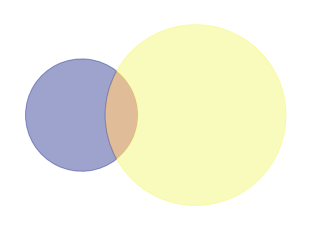

In [72]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles

v = venn2(subsets = (55023, 164348, 13796), set_labels = ("","",""))
v.patches[0].set_color("#0b1b82")
v.patches[1].set_color('#f2f758')
for idx, subset in enumerate(v.subset_labels):
    v.subset_labels[idx].set_visible(False)
plt.savefig("venn.png",dpi=300)
plt.show()